In [33]:
import pyspark.sql.functions as f
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [2]:
import findspark
findspark.init()

import pyspark
conf = (
    pyspark.SparkConf()
        .setMaster('local[*]')
)
sc = pyspark.SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
from pyspark.sql import SQLContext
spark = SQLContext(sc)

from pyspark.sql.types import StringType, ShortType, IntegerType, DoubleType, StructType, StructField, BooleanType
df_schema = StructType([
                        StructField('property_type',StringType()),
                        StructField('price',StringType()),
                        StructField('location',StringType()),
                        StructField('city',StringType()),
                        StructField('bath',StringType()),
                        StructField('purpose',StringType()),
                        StructField('bedrooms',StringType()),
                        StructField('area_in_marla',StringType())
                        ])

df = spark.read.csv("house_prices.csv",schema=df_schema, header = True)

df.show(5)


+-------------+------------+---------------+-------------+-----+------------+--------+-------------+
|property_type|       price|       location|         city| bath|     purpose|bedrooms|area_in_marla|
+-------------+------------+---------------+-------------+-----+------------+--------+-------------+
|  "0,""Flat""|""10000000""|       ""G-10""|""Islamabad""|""2""|""For Sale""|   ""2""|       ""4"""|
|  "1,""Flat""| ""6900000""|       ""E-11""|""Islamabad""|""3""|""For Sale""|   ""3""|     ""5.6"""|
| "2,""House""|""16500000""|       ""G-15""|""Islamabad""|""6""|""For Sale""|   ""5""|       ""8"""|
| "3,""House""|""43500000""|  ""Bani Gala""|""Islamabad""|""4""|""For Sale""|   ""4""|      ""40"""|
| "4,""House""| ""7000000""|""DHA Defence""|""Islamabad""|""3""|""For Sale""|   ""3""|       ""8"""|
+-------------+------------+---------------+-------------+-----+------------+--------+-------------+
only showing top 5 rows



## Check shape of data 

In [4]:
num_rows = df.count()

num_columns = len(df.columns)

# Print the shape
print("Shape of DataFrame: ({}, {})".format(num_rows, num_columns))

Shape of DataFrame: (99499, 8)


In [6]:
#df = df.withColumn("id", regexp_extract(df["property_type"], r'(\d+)', 1).cast(StringType()))

# Showing the modified DataFrame
df.show(20)

+----------------+------------+--------------------+-------------+-----+------------+--------+-------------+
|   property_type|       price|            location|         city| bath|     purpose|bedrooms|area_in_marla|
+----------------+------------+--------------------+-------------+-----+------------+--------+-------------+
|     "0,""Flat""|""10000000""|            ""G-10""|""Islamabad""|""2""|""For Sale""|   ""2""|       ""4"""|
|     "1,""Flat""| ""6900000""|            ""E-11""|""Islamabad""|""3""|""For Sale""|   ""3""|     ""5.6"""|
|    "2,""House""|""16500000""|            ""G-15""|""Islamabad""|""6""|""For Sale""|   ""5""|       ""8"""|
|    "3,""House""|""43500000""|       ""Bani Gala""|""Islamabad""|""4""|""For Sale""|   ""4""|      ""40"""|
|    "4,""House""| ""7000000""|     ""DHA Defence""|""Islamabad""|""3""|""For Sale""|   ""3""|       ""8"""|
|     "7,""Flat""| ""7800000""|            ""E-11""|""Islamabad""|""2""|""For Sale""|   ""2""|     ""6.2"""|
|"9,""Penthouse""|"

### Change data type of data

In [7]:
for col_name in df.columns:
    if col_name == "property_type":
        df = df.withColumn('property_type', regexp_replace(df['property_type'], '[0-9"",]', ''))
    else:
        df = df.withColumn(col_name, regexp_replace(df[col_name], '"', ''))

df.show(5)

+-------------+--------+-----------+---------+----+--------+--------+-------------+
|property_type|   price|   location|     city|bath| purpose|bedrooms|area_in_marla|
+-------------+--------+-----------+---------+----+--------+--------+-------------+
|         Flat|10000000|       G-10|Islamabad|   2|For Sale|       2|            4|
|         Flat| 6900000|       E-11|Islamabad|   3|For Sale|       3|          5.6|
|        House|16500000|       G-15|Islamabad|   6|For Sale|       5|            8|
|        House|43500000|  Bani Gala|Islamabad|   4|For Sale|       4|           40|
|        House| 7000000|DHA Defence|Islamabad|   3|For Sale|       3|            8|
+-------------+--------+-----------+---------+----+--------+--------+-------------+
only showing top 5 rows



In [8]:
df.printSchema()

root
 |-- property_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- location: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bath: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- area_in_marla: string (nullable = true)



In [9]:
columns_to_convert = ['price', 'bath', 'bedrooms', 'area_in_marla']

for col in columns_to_convert:
    df = df.withColumn(col, df[col].cast(IntegerType()))
    
df = df.drop("location")
    
df.show(5)

+-------------+--------+---------+----+--------+--------+-------------+
|property_type|   price|     city|bath| purpose|bedrooms|area_in_marla|
+-------------+--------+---------+----+--------+--------+-------------+
|         Flat|10000000|Islamabad|   2|For Sale|       2|            4|
|         Flat| 6900000|Islamabad|   3|For Sale|       3|            5|
|        House|16500000|Islamabad|   6|For Sale|       5|            8|
|        House|43500000|Islamabad|   4|For Sale|       4|           40|
|        House| 7000000|Islamabad|   3|For Sale|       3|            8|
+-------------+--------+---------+----+--------+--------+-------------+
only showing top 5 rows



## Check missing value 

In [10]:
from pyspark.sql.functions import col, sum as spark_sum

missing_values = df.select(*(spark_sum(col(c).isNull().cast('int')).alias(c) for c in df.columns))
missing_values.show()

+-------------+-----+----+----+-------+--------+-------------+
|property_type|price|city|bath|purpose|bedrooms|area_in_marla|
+-------------+-----+----+----+-------+--------+-------------+
|            0|    0|   0|   8|      0|       8|            0|
+-------------+-----+----+----+-------+--------+-------------+



In [11]:
df = df.dropna()

## Check Inconsistent data

In [12]:
string_columns = ['property_type', 'city', 'purpose']

for col_name in string_columns:
    unique_values = df.select(col_name).distinct().collect()
    print("Unique values for column '{}':".format(col_name))
    for value in unique_values:
        print(value[col_name])
    print("\n")

Unique values for column 'property_type':
Farm House
Flat
Penthouse
Room
House
Upper Portion
Lower Portion


Unique values for column 'city':
Karachi
Lahore
Faisalabad
Rawalpindi
Islamabad


Unique values for column 'purpose':
For Rent
For Sale




In [13]:
df = df.filter(col("price") > 0)

## Encoding Data 

In [16]:
df.show(5)

+-------------+--------+---------+----+--------+--------+-------------+
|property_type|   price|     city|bath| purpose|bedrooms|area_in_marla|
+-------------+--------+---------+----+--------+--------+-------------+
|         Flat|10000000|Islamabad|   2|For Sale|       2|            4|
|         Flat| 6900000|Islamabad|   3|For Sale|       3|            5|
|        House|16500000|Islamabad|   6|For Sale|       5|            8|
|        House|43500000|Islamabad|   4|For Sale|       4|           40|
|        House| 7000000|Islamabad|   3|For Sale|       3|            8|
+-------------+--------+---------+----+--------+--------+-------------+
only showing top 5 rows



In [17]:
categorical_columns = ['property_type', 'city', 'purpose']

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in categorical_columns]
indexed_df = df
for indexer in indexers:
    indexed_df = indexer.transform(indexed_df)


encoder = OneHotEncoder(inputCols=[column+"_index" for column in categorical_columns],
                        outputCols=[column+"_encoded" for column in categorical_columns])
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

encoded_df = encoded_df.drop(*[column+"_index" for column in categorical_columns])
df_encoded = encoded_df.select("property_type_encoded", "city_encoded", "purpose_encoded", "price", "bath", "bedrooms", "area_in_marla")


In [30]:
df_encoded.show()

+---------------------+-------------+---------------+--------+----+--------+-------------+
|property_type_encoded| city_encoded|purpose_encoded|   price|bath|bedrooms|area_in_marla|
+---------------------+-------------+---------------+--------+----+--------+-------------+
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|10000000|   2|       2|            4|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 6900000|   3|       3|            5|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|16500000|   6|       5|            8|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|43500000|   4|       4|           40|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7000000|   3|       3|            8|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7800000|   2|       2|            6|
|        (6,[4],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|40000000|   5|       5|           20|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|35000000|   3|       3|            7|

## Feature Visualization

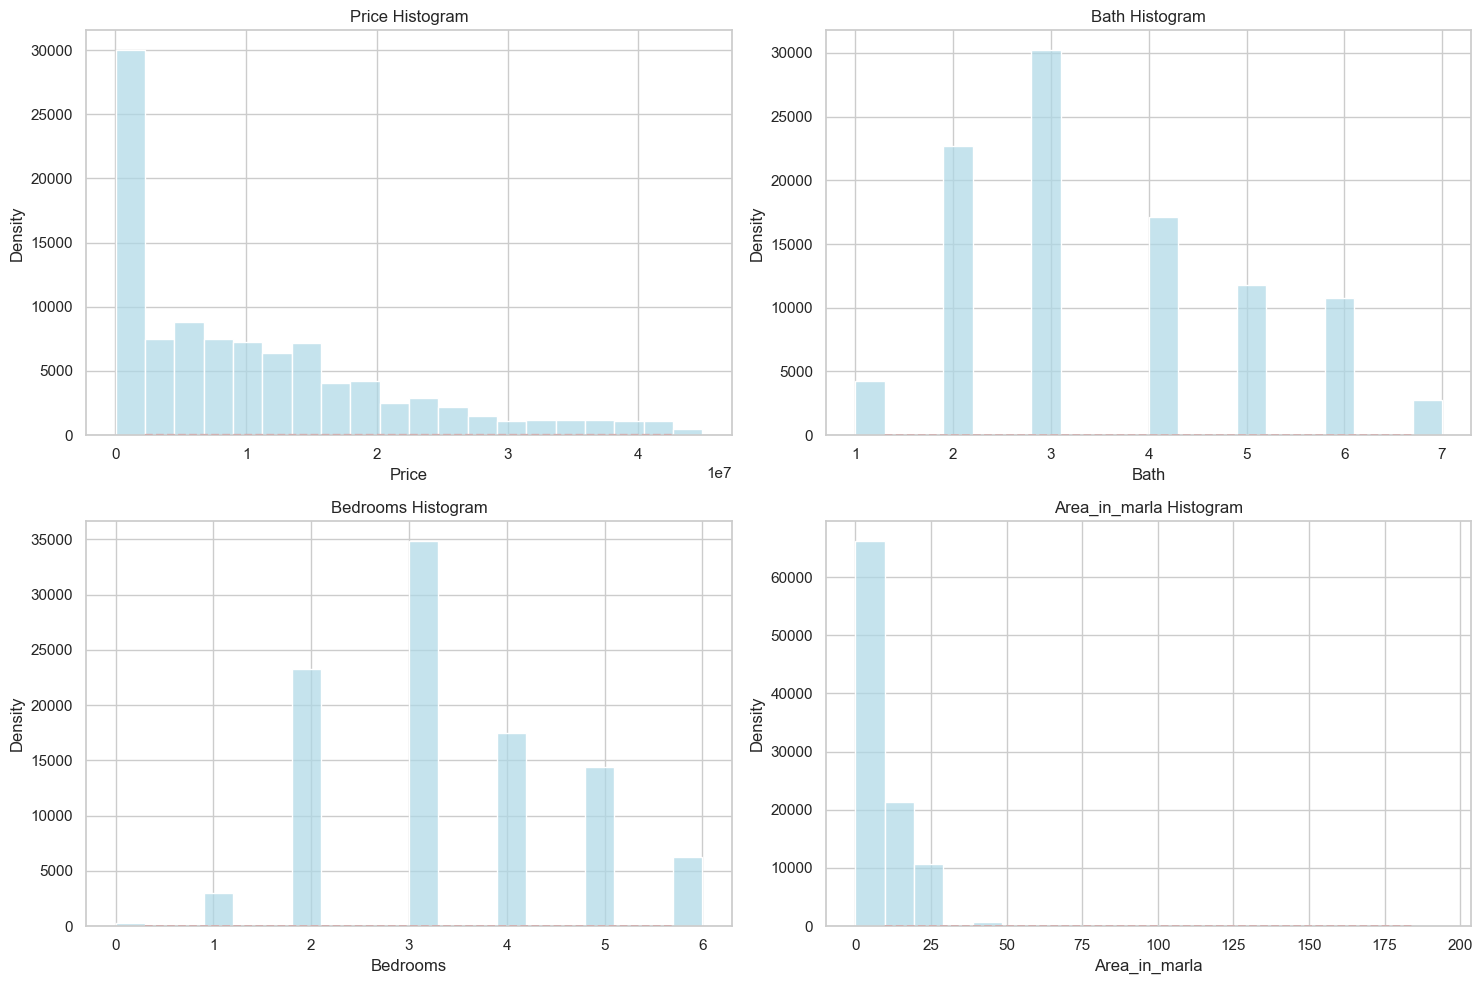

In [47]:
df_pd = df_encoded.toPandas()

numerical_columns = ['price', 'bath', 'bedrooms', 'area_in_marla']
num_rows = (len(numerical_columns) + 1) // 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0, wspace=0)

if num_rows > 1:
    axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(df_pd[col], bins=20, color='lightblue', alpha=0.7, ax=ax)
    hist, bins = np.histogram(df_pd[col], bins=10, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax.plot(bin_centers, hist, color='red', linestyle='--')
    ax.set_title(f'{col.capitalize()} Histogram')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

Shape before cleansing: (99491, 7)


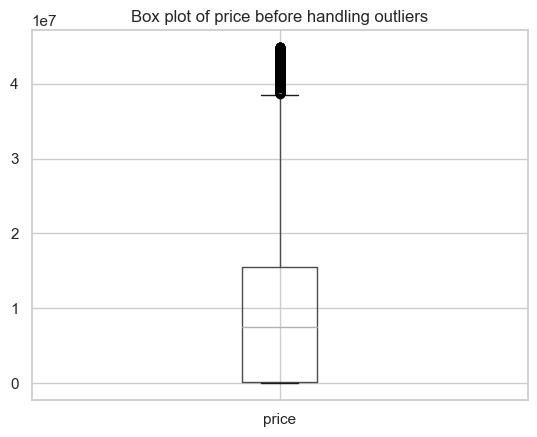

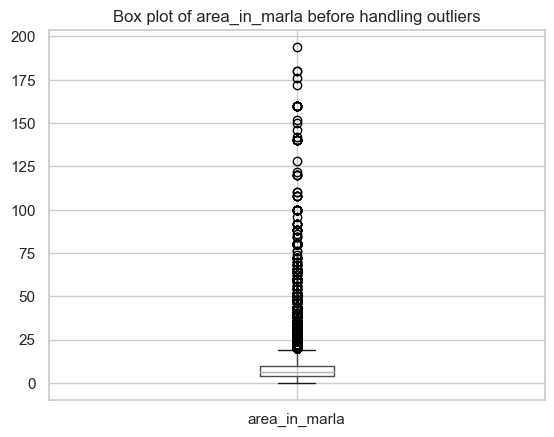

Number of outliers in column 'price': 4840
Number of outliers in column 'area_in_marla': 11869
Shape after cleansing: (85344, 7)


In [50]:
from pyspark.sql.functions import col, when

def handle_outliers(df, columns, action='remove'):
    print("Shape before cleansing:", (df.count(), len(df.columns)))

    result_df = df
    
    for column in columns:
        df.select(column).toPandas().boxplot()
        plt.title(f'Box plot of {column} before handling outliers')
        plt.show()

    for column in columns:
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
        q1 = quantiles[0]
        q3 = quantiles[1]
        iqr = q3 - q1

        # Define bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Count outliers
        outliers_count = df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
        print(f"Number of outliers in column '{column}': {outliers_count}")

        if action == 'remove':
            result_df = result_df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        elif action == 'cap':
            result_df = result_df.withColumn(column, when(col(column) < lower_bound, lower_bound).when(col(column) > upper_bound, upper_bound).otherwise(col(column)))
        elif action == 'pass':
            pass
        else:
            raise ValueError("Invalid action. Supported actions: 'remove', 'cap_lower', 'cap_upper', 'pass'")

    print("Shape after cleansing:", (result_df.count(), len(result_df.columns)))

    return result_df


columns_to_handle = ['price', 'area_in_marla']
action_to_take = 'remove'  
df_handled = handle_outliers(df_encoded, columns_to_handle, action=action_to_take)


In [25]:
df_handled.show()

+---------------------+-------------+---------------+--------+----+--------+-------------+
|property_type_encoded| city_encoded|purpose_encoded|   price|bath|bedrooms|area_in_marla|
+---------------------+-------------+---------------+--------+----+--------+-------------+
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|10000000|   2|       2|            4|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 6900000|   3|       3|            5|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|16500000|   6|       5|            8|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7000000|   3|       3|            8|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7800000|   2|       2|            6|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|13500000|   5|       3|           10|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 3600000|   1|       1|            3|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 5000000|   2|       2|            4|

In [26]:
assembler = VectorAssembler(
    inputCols=["property_type_encoded", "city_encoded", "purpose_encoded", "bath", "bedrooms", "area_in_marla"],
    outputCol="features")

df_assembled = assembler.transform(df_handled)
df_assembled.show()

+---------------------+-------------+---------------+--------+----+--------+-------------+--------------------+
|property_type_encoded| city_encoded|purpose_encoded|   price|bath|bedrooms|area_in_marla|            features|
+---------------------+-------------+---------------+--------+----+--------+-------------+--------------------+
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|10000000|   2|       2|            4|(14,[1,8,10,11,12...|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 6900000|   3|       3|            5|(14,[1,8,10,11,12...|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|16500000|   6|       5|            8|(14,[0,8,10,11,12...|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7000000|   3|       3|            8|(14,[0,8,10,11,12...|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7800000|   2|       2|            6|(14,[1,8,10,11,12...|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|13500000|   5|       3|           10|(14,[1,8,10,11

In [27]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [28]:
df_scaled.show()

+---------------------+-------------+---------------+--------+----+--------+-------------+--------------------+--------------------+
|property_type_encoded| city_encoded|purpose_encoded|   price|bath|bedrooms|area_in_marla|            features|     scaled_features|
+---------------------+-------------+---------------+--------+----+--------+-------------+--------------------+--------------------+
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|10000000|   2|       2|            4|(14,[1,8,10,11,12...|(14,[1,8,10,11,12...|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 6900000|   3|       3|            5|(14,[1,8,10,11,12...|(14,[1,8,10,11,12...|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])|16500000|   6|       5|            8|(14,[0,8,10,11,12...|(14,[0,8,10,11,12...|
|        (6,[0],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7000000|   3|       3|            8|(14,[0,8,10,11,12...|(14,[0,8,10,11,12...|
|        (6,[1],[1.0])|(4,[2],[1.0])|  (1,[0],[1.0])| 7800000|   2|  

In [29]:
final_data = df_scaled.select("scaled_features", "price")
final_data.show(5)

+--------------------+--------+
|     scaled_features|   price|
+--------------------+--------+
|(14,[1,8,10,11,12...|10000000|
|(14,[1,8,10,11,12...| 6900000|
|(14,[0,8,10,11,12...|16500000|
|(14,[0,8,10,11,12...| 7000000|
|(14,[1,8,10,11,12...| 7800000|
+--------------------+--------+
only showing top 5 rows



## Train Test Split

In [52]:
train_data, test_data = final_data .randomSplit([0.7, 0.3], seed=42)

## linear regression, Visualization

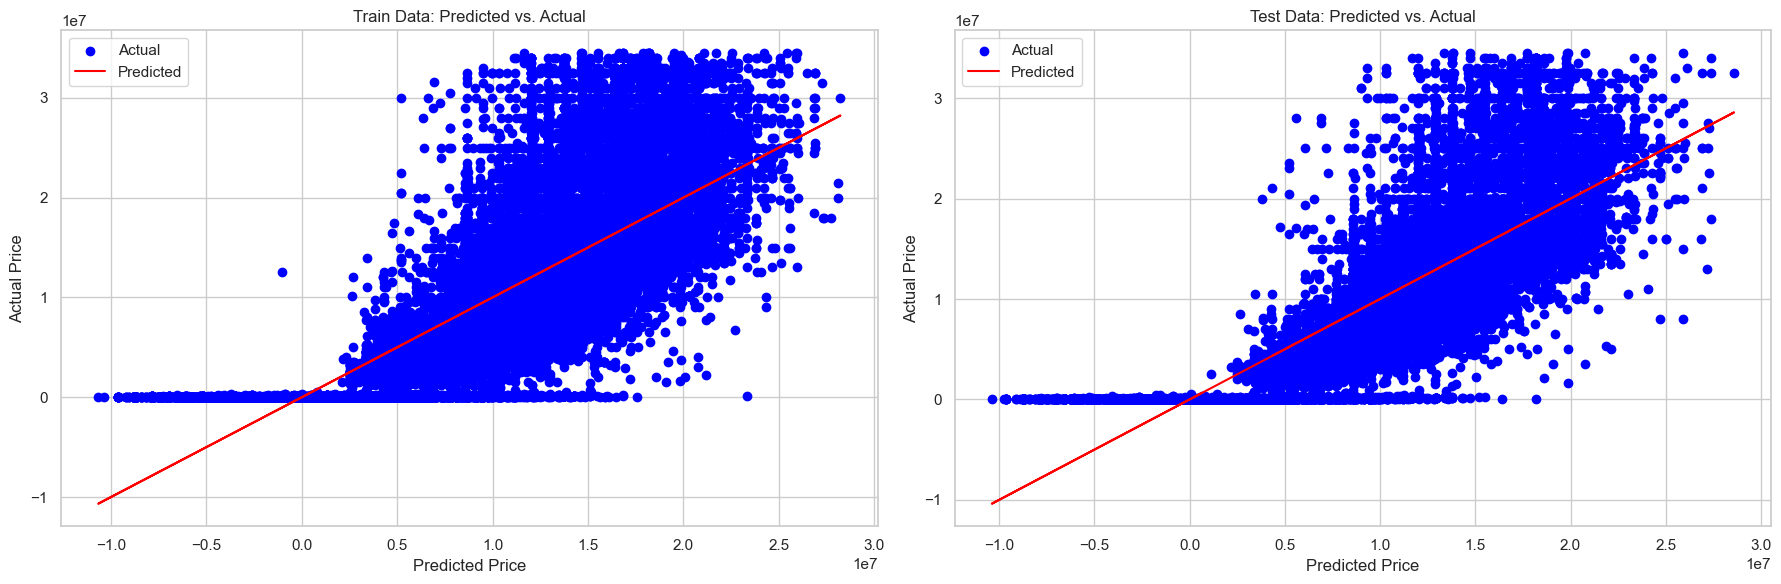

In [58]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np
lr = LinearRegression(featuresCol="scaled_features", labelCol="price")
lr_model = lr.fit(train_data)
predictions_train = lr_model.transform(train_data)
predictions_test = lr_model.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")

train_mae = evaluator.evaluate(predictions_train, {evaluator.metricName: "mae"})
test_mae = evaluator.evaluate(predictions_test, {evaluator.metricName: "mae"})

train_rmse = evaluator.evaluate(predictions_train, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(predictions_test, {evaluator.metricName: "rmse"})

train_mse = evaluator.evaluate(predictions_train, {evaluator.metricName: "mse"})
test_mse = evaluator.evaluate(predictions_test, {evaluator.metricName: "mse"})

# Visualization
predictions_train_pd = predictions_train.select("price", "prediction").toPandas()
predictions_test_pd = predictions_test.select("price", "prediction").toPandas()

plt.figure(figsize=(18, 6))

# Plot for train data
plt.subplot(1, 2, 1)
plt.scatter(predictions_train_pd["prediction"], predictions_train_pd["price"], color='blue', label='Actual')
plt.plot(predictions_train_pd["prediction"], predictions_train_pd["prediction"], color='red', label='Predicted') 
plt.title("Train Data: Predicted vs. Actual")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.grid(True)
plt.legend()

# Plot for test data
plt.subplot(1, 2, 2)
plt.scatter(predictions_test_pd["prediction"], predictions_test_pd["price"], color='blue', label='Actual')
plt.plot(predictions_test_pd["prediction"], predictions_test_pd["prediction"], color='red', label='Predicted') 
plt.title("Test Data: Predicted vs. Actual")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

##  Evaluation Model

In [59]:
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)


Train MAE: 3684701.9450599425
Test MAE: 3674413.5304523865
Train RMSE: 4776356.356981298
Test RMSE: 4758605.250207166
Train MSE: 22813580048875.656
Test MSE: 22644323927299.203
